# Lab Data

Utilities and results of looking for sensor artifacts in lab data.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import os.path

In [3]:
import matplotlib.patheffects
import mpl_toolkits.axes_grid.inset_locator

In [4]:
import fitsio

In [5]:
import numpy.lib.stride_tricks

In [6]:
import scipy.stats

## Utilities

In [7]:
def block_view(A, block_shape):
    """Provide a 2D block view of a 2D array.
    
    Returns a view with shape (n, m, a, b) for an input 2D array with
    shape (n*a, m*b) and block_shape of (a, b).
    """
    assert len(A.shape) == 2, '2D input array is required.'
    assert A.shape[0] % block_shape[0] == 0, 'Block shape[0] does not evenly divide array shape[0].'
    assert A.shape[1] % block_shape[1] == 0, 'Block shape[1] does not evenly divide array shape[1].'
    shape = (A.shape[0] / block_shape[0], A.shape[1] / block_shape[1]) + block_shape
    strides = (block_shape[0] * A.strides[0], block_shape[1] * A.strides[1]) + A.strides
    return numpy.lib.stride_tricks.as_strided(A, shape=shape, strides=strides)

In [8]:
def apply_filter(A, smoothing, power=2.0):
    """Apply a hi/lo pass filter to a 2D image.
    
    The value of smoothing specifies the cutoff wavelength in pixels,
    with a value >0 (<0) applying a hi-pass (lo-pass) filter. The
    lo- and hi-pass filters sum to one by construction.  The power
    parameter determines the sharpness of the filter, with higher
    values giving a sharper transition.
    """
    if smoothing == 0:
        return A
    ny, nx = A.shape
    # Round down dimensions to even values for rfft.
    # Any trimmed row or column will be unfiltered in the output.
    nx = 2 * (nx // 2)
    ny = 2 * (ny // 2)
    T = np.fft.rfft2(A[:ny, :nx])
    # Last axis (kx) uses rfft encoding.
    kx = np.fft.rfftfreq(nx)
    ky = np.fft.fftfreq(ny)
    kpow = (kx ** 2 + ky[:, np.newaxis] ** 2) ** (power / 2.)
    k0pow = (1. / smoothing) ** power
    if smoothing > 0:
        F = kpow / (k0pow + kpow) # high pass
    else:
        F = k0pow / (k0pow + kpow) # low pass
    S = A.copy()
    S[:ny, :nx] = np.fft.irfft2(T * F)
    return S

In [9]:
def zero_by_region(data, region_shape, num_sigmas_clip=4.0, smoothing=250, power=4):
    """Subtract the clipped median signal in each amplifier region.
    
    Optionally also remove any smooth variation in the mean signal with
    a high-pass filter controlled by the smoothing and power parameters.
    Returns a an array of median levels in each region and a mask of
    unclipped pixels.
    """
    mask = np.zeros_like(data, dtype=bool)

    # Loop over amplifier regions.
    regions = block_view(data, region_shape)
    masks = block_view(mask, region_shape)
    ny, nx = regions.shape[:2]
    levels = np.empty((ny, nx))
  
    for y in range(ny):
        for x in range(nx):
            region_data = regions[y, x]
            region_mask = masks[y, x]
            clipped1d, lo, hi = scipy.stats.sigmaclip(
                region_data, num_sigmas_clip, num_sigmas_clip)
            # Add unclipped pixels to the mask.
            region_mask[(region_data > lo) & (region_data < hi)] = True            
            # Subtract the clipped median in place.
            levels[y, x] = np.median(clipped1d)
            region_data -= levels[y, x]
            # Smooth this region's data.
            if smoothing != 0:
                clipped_data = region_data[~region_mask]
                region_data[~region_mask] = 0.
                region_data[:] = apply_filter(region_data, smoothing, power)
                region_data[~region_mask] = clipped_data
                
    return levels, mask

In [10]:
def equalize(A, clip_percent=5):
    """Equalize the values of an array.
    
    The returned array has values between 0-1 such that clip_percent
    of the values are clipped symmetrically at 0 and 1, and the
    histogram of values between 0 and 1 is flat. This is a non-linear
    transformation and primarily useful for showing small variations
    over a large dynamic range.
    """
    A_flat = A.reshape(-1)
    n = len(A_flat)
    num_clip = round(n * clip_percent / 100.)
    num_clip_lo = num_clip // 2
    num_clip_hi = num_clip - num_clip_lo
    equalized = np.empty_like(A_flat, dtype=float)
    order = np.argsort(A_flat)
    equalized[order] = np.clip(
        (np.arange(n) - num_clip_lo) / float(n - num_clip), 0., 1.)
    return equalized.reshape(A.shape)

In [11]:
def downsample(data, mask, downsampling):
    """Downsample a masked image by the specified integer factor.
    
    The returned data is the average of unmasked input pixel values
    within each downsampled block.  The returned mask selects downsampled
    blocks with at least one unmasked input pixel.
    """
    downsampling = int(downsampling)
    assert downsampling > 0, 'Expected downsampling > 0.'
    npix = block_view(mask, (downsampling, downsampling)).sum(axis=(2, 3))
    mask = npix > 0
    data = block_view(data, (downsampling, downsampling)).sum(axis=(2, 3))
    data[mask] /= npix[mask]
    return data, mask

In [12]:
def measure_profile(data, mask, line_start, line_stop, sigma=50, num_bins=50):
    """Measure a 1D profile along a line through 2D data.
    
    The sigma parameter determines the effective width of the measurement line
    in units of pixels, and is used to apply Gaussian weights as a function of
    transverse distance from the line. Returns a pair of functions to draw the
    measurement line and measured profile.
    """
    x1, y1 = line_start
    x2, y2 = line_stop
    dx, dy = x2 - x1, y2 - y1
    dr = np.sqrt(dx ** 2 + dy ** 2)
    
    # Calculate the rotation angle that puts the line along +x.
    th = np.arctan2(dy, dx)
    sin_th, cos_th = np.sin(th), np.cos(th)
    
    # Calculate pixel distances relative to the line.
    ny, nx = data.shape
    x, y = np.arange(nx), np.arange(ny)[:, np.newaxis]    
    u = (cos_th * (x - x1) + sin_th * (y - y1))
    v = (-sin_th * (x - x1) + cos_th * (y - y1))
    
    # Use Gaussian weighting in the transverse direction.
    wgt = np.exp(-0.5 * (v / sigma) ** 2)
    M = mask & (u >= 0) & (u <= dr)

    # Calculate the 1D profile histogram.
    D = u[M].reshape(-1)
    W1 = data[M].reshape(-1)
    W2 = wgt[M].reshape(-1)
    profile, edges = np.histogram(D, bins=num_bins, range=(0, dr), weights=W1 * W2)
    wsum, edges = np.histogram(D, bins=num_bins, range=(0, dr), weights=W2)
    profile /= wsum
    centers = edges[1:] - 0.5 * dr / num_bins
    ymax = 1.1 * np.max(np.abs(profile))
    
    # Draw the measurement line on scaled axes. The width indicates +/-sigma.
    corners = np.array([[0, -sigma], [0, +sigma], [dr, +sigma], [dr, -sigma]])
    R = np.array([[cos_th, sin_th], [-sin_th, cos_th]])
    corners = corners.dot(R)
    corners += [x1, y1]
    def draw_line(axes, scale):
        poly = matplotlib.patches.Polygon(
            corners / scale, fc='w', ec='k', alpha=0.75)
        axes.add_patch(poly)

    # Profile has x units of pixels and y units of ADU. Axis values are not
    # drawn but grid line spacing is fixed at the specified values.
    def draw_profile(axes, xgrid=10, ygrid=2):
        print 'Profile grid spacing is {0} pixels, {1} ADU.'.format(xgrid, ygrid)
        axes.plot(centers, profile, 'k.-')
        axes.set_xlim(0, dr)
        axes.set_ylim(-ymax, +ymax)        
        axes.set_xticks(np.arange(0, dr, xgrid))
        ygrid = np.arange(ygrid, ymax, ygrid)
        axes.set_yticks(np.hstack((-ygrid[::-1], ygrid)))
        axes.grid(c='b', ls='-', alpha=0.5)
        axes.axhline(0, c='r', ls='-', lw=2)
        # This removes the axis labels but not the space they occupied.
        axes.xaxis.set_ticklabels([])
        axes.yaxis.set_ticklabels([])
        
    return draw_line, draw_profile

In [13]:
def add_label(label, label_pos='tr', label_size=0.025, axes=None):
    """Annotate the current plot with a text label.
    """
    if axes is None:
        axes = plt.gca()
    args = {
        'tr': dict(xy=(0.99, 0.99), xytext=(0.99, 0.99), ha='right', va='top'),
        'tl': dict(xy=(0.01, 0.99), xytext=(0.01, 0.99), ha='left', va='top'),
        'bl': dict(xy=(0.01, 0.01), xytext=(0.01, 0.01), ha='left', va='bottom'),
        'br': dict(xy=(0.01, 0.99), xytext=(0.99, 0.01), ha='right', va='bottom')
    }[label_pos]
    size = label_size * (axes.transAxes.transform((0, 1))[1] -
                         axes.transAxes.transform((0, 0))[1])
    axes.annotate(
        label, xycoords='axes fraction', textcoords='axes fraction',
        fontsize=size, fontweight='bold', color='white', path_effects=[
            matplotlib.patheffects.Stroke(linewidth=1, foreground='black')],
        **args)

In [14]:
def plot_pixels(data, lo, hi, cmap='plasma', dpi=150.):
    """Create an image with pixel dimensions that match the data dimensions.
    """
    h, w = data.shape
    figure = plt.figure(figsize=(w/dpi, h/dpi), frameon=False, dpi=dpi)  
    axes = plt.Axes(figure, [0., 0., 1., 1.])
    axes.axis(xmin=-0.5, xmax=w-0.5, ymin=-0.5, ymax=h-0.5)
    axes.set_axis_off()
    figure.add_axes(axes)
    plt.imshow(data, interpolation='none', vmin=lo, vmax=hi, cmap=cmap,
               aspect='equal', origin='lower')
    plt.axis('off')
    return figure, axes

In [15]:
def create_inset(axes, location='br', width='40%', height='30%'):
    """Create axes for an inset plot.
    """
    loc = dict(tr=1, tl=2, bl=3, br=4, l=6,
               r=7, b=8, t=9, c=10)
    try:
        loc = loc[location]
    except KeyError:
        raise ValueError('location must be one of {0}.'.format(loc.keys()))
    return mpl_toolkits.axes_grid.inset_locator.inset_axes(
        axes, width, height, loc=loc)

## ITL Sensors

Display ITL sensor data within the directory `$ITL_DATA`.

In [16]:
def plot_itl(filename, num_sigmas_clip=4.0, smoothing=250, zoom=None, downsampling=4,
             clip_percent=10., measure_line=((292, 1024), (468, 872)), inset_loc='tr',
             equalized=False, label=None, label_pos='tl', save=None):
    
    data = fitsio.read(os.path.join(os.environ['ITL_DATA'], filename))
    levels, mask = zero_by_region(data, (2000, 509), num_sigmas_clip, smoothing)
    level = np.median(levels)
    print 'Median signal is {:.2f} ADU.'.format(level)
    
    if measure_line:
        draw_line, draw_profile = measure_profile(data, mask, *measure_line)
    
    if zoom:
        data, mask = data[zoom], mask[zoom]
        
    if downsampling:
        data, mask = downsample(data, mask, downsampling)
    
    if equalized:
        data = equalize(data, clip_percent) - 0.5

    # Get the clip range to use for plotting.
    lo, hi = np.percentile(
        data[mask].ravel(), (0.5 * clip_percent, 100 - 0.5 * clip_percent))
    
    figure, axes = plot_pixels(data, lo, hi)
    
    # Draw the line profile if any.
    if measure_line:
        draw_line(axes, downsampling)
        draw_profile(create_inset(axes, inset_loc))
    
    if label:
        add_label(label, label_pos, axes=axes)
    if save:
        plt.savefig(save, dpi=figure.dpi)

Examine FITS files provided by HyeYun Park (SUNY) of data taken at BNL.

In [17]:
os.environ['ITL_DATA'] = '/Data/ITL'

Median signal is 4212.50 ADU.
Profile grid spacing is 10 pixels, 2 ADU.


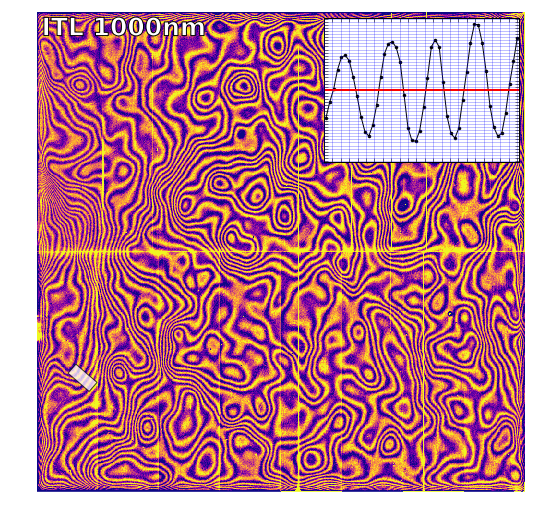

In [18]:
plot_itl('ITL-3800C-107_lambda_flat_1000_067_20160920014450_assembled.fits',
         label='ITL 1000nm', save='itl1000.png')

Median signal is 5272.50 ADU.
Profile grid spacing is 10 pixels, 2 ADU.


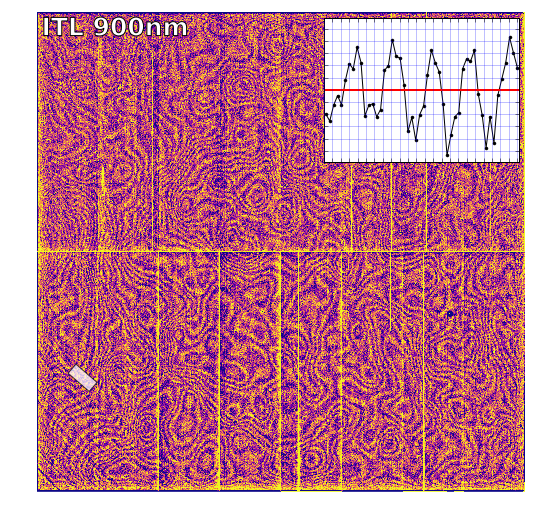

In [19]:
plot_itl('ITL-3800C-107_lambda_flat_0900_057_20160920012003_assembled.fits',
         label='ITL 900nm', save='itl900.png')

Median signal is 566.50 ADU.
Profile grid spacing is 10 pixels, 2 ADU.


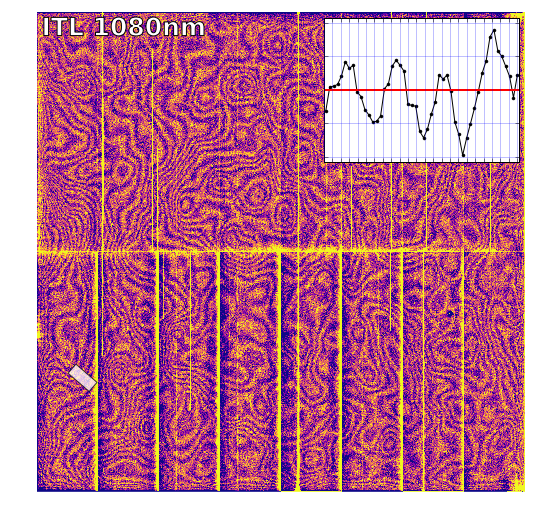

In [20]:
plot_itl('ITL-3800C-107_lambda_flat_1080_075_20160920022630_assembled.fits',
         label='ITL 1080nm', save='itl1080.png')

Median signal is 5080.00 ADU.
Profile grid spacing is 10 pixels, 2 ADU.


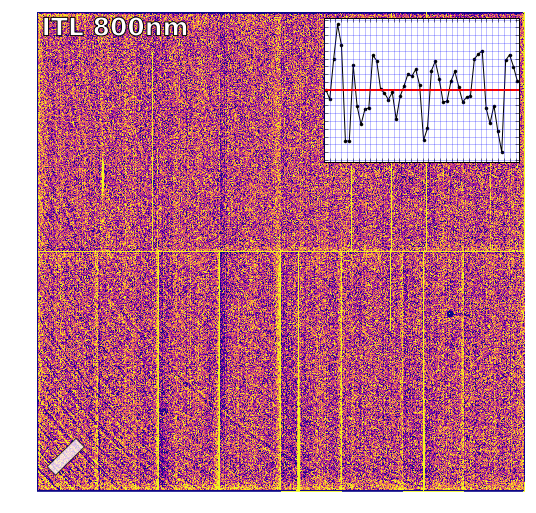

In [21]:
plot_itl('ITL-3800C-107_lambda_flat_0800_048_20160920010149_assembled.fits',
         label='ITL 800nm', save='itl800.png', measure_line=((120, 172), (360, 408)))

Median signal is 5311.50 ADU.
Profile grid spacing is 10 pixels, 2 ADU.


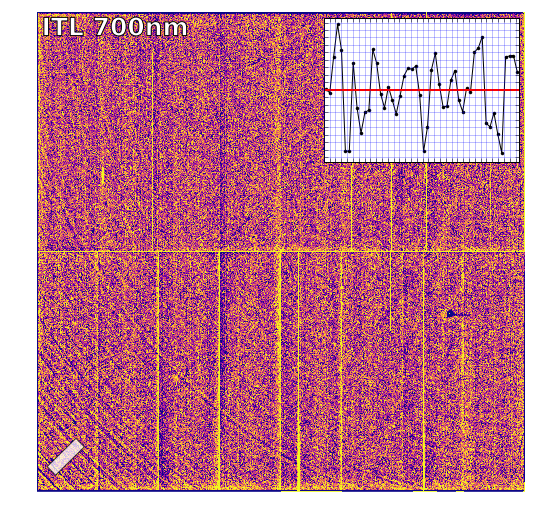

In [22]:
plot_itl('ITL-3800C-107_lambda_flat_0700_038_20160920003813_assembled.fits',
         label='ITL 700nm', save='itl700.png', measure_line=((120, 172), (360, 408)))

Median signal is 5395.50 ADU.
Profile grid spacing is 10 pixels, 2 ADU.


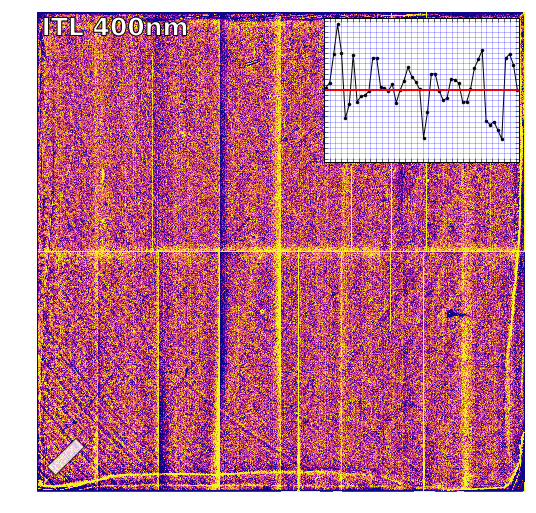

In [23]:
plot_itl('ITL-3800C-107_lambda_flat_0400_008_20160919233039_assembled.fits',
         label='ITL 400nm', save='itl400.png', measure_line=((120, 172), (360, 408)))